### Loading Dependencies

In [77]:
# Data Manipulation
import pandas as pd
import numpy as np
# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Other
from datetime import datetime

### Loading Dataset

In [2]:
# Load dataset
raw_data = pd.read_csv('data.csv', sep = ',')
raw_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Data Quality Assessment

In [3]:
# Checking for duplicate entries
raw_data['ID'].duplicated().any()

False

In [4]:
# Checking data types, missing data
raw_data.info()
# Total records # 378661
# usd_pledged and name have null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


##### Handling missing data
**name**
* As long as ID is not null, missing name can be replaced with 'Unnamed'. Once the prediction is available, it can be tied back using Project ID. In this dataset, ID is available for entire dataset, therefore name column can be dropped

**usd_pledged**
* usd_pledged_real has the corressponding usd conversion for all records hence usd_pledged field can be dropped

In [5]:
raw_data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [6]:
# Creating a copy of the dataset for this problem
raw_data_cp = raw_data

### Data Preparation

In [7]:
# Replacing null values in 'name' column with 'Unnamed'
raw_data['name'].fillna('Unnamed', inplace = True)

In [8]:
# Dropping redundant columns
raw_data.drop(['usd pledged', 'currency', 'goal', 'pledged'], axis = 1, inplace = True)

In [9]:
raw_data['deadline'] = pd.to_datetime(raw_data['deadline'], infer_datetime_format=True)

In [10]:
raw_data['launched'] = pd.to_datetime(raw_data['launched'], infer_datetime_format=True)

In [11]:
launched_year = raw_data['launched'].dt.year.unique()
launched_year

array([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 1970, 2018])

In [12]:
# Checking info projects launched in 1970
# len(raw_data[raw_data['launched'].dt.year == 1970]) # 7 projects
raw_data[raw_data['launched'].dt.year == 1970] # 6 canceled and 1 suspended. All 7 projects can be dropped

,ID,name,category,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
2842,1014746686,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,2010-09-15,1970-01-01 01:00:00,canceled,0,US,0.0,5000.00
48147,1245461087,1st Super-Size Painting - Social Network Owned...,Art,Art,2010-08-14,1970-01-01 01:00:00,canceled,0,US,0.0,15000.00
75397,1384087152,"""ICHOR"" (Canceled)",Film & Video,Film & Video,2010-05-21,1970-01-01 01:00:00,canceled,0,US,0.0,700.00
94579,1480763647,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,2010-06-01,1970-01-01 01:00:00,canceled,0,US,0.0,4000.00
247913,330942060,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,2010-05-04,1970-01-01 01:00:00,canceled,0,US,0.0,10000.00
273779,462917959,Identity Communications Infographic (Canceled),Design,Design,2010-04-10,1970-01-01 01:00:00,canceled,0,US,0.0,500.00
319002,69489148,Student Auditions Music 2015,Publishing,Publishing,2015-10-31,1970-01-01 01:00:00,suspended,0,CH,0.0,1905.97


In [13]:
raw_data.drop(raw_data[raw_data.launched.dt.year == 1970].index, inplace=True)

In [14]:
raw_data['duration_running'] = (raw_data['deadline'] - raw_data['launched']).dt.days

In [15]:
raw_data.drop(['deadline', 'launched'], axis = 1, inplace = True)

In [16]:
raw_data.head()

,ID,name,category,main_category,state,backers,country,usd_pledged_real,usd_goal_real,duration_running
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,failed,0,GB,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,failed,15,US,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,failed,3,US,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,failed,1,US,1.0,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,canceled,14,US,1283.0,19500.00,55


### Exploratory Data Analysis

##### Quick check for correlations

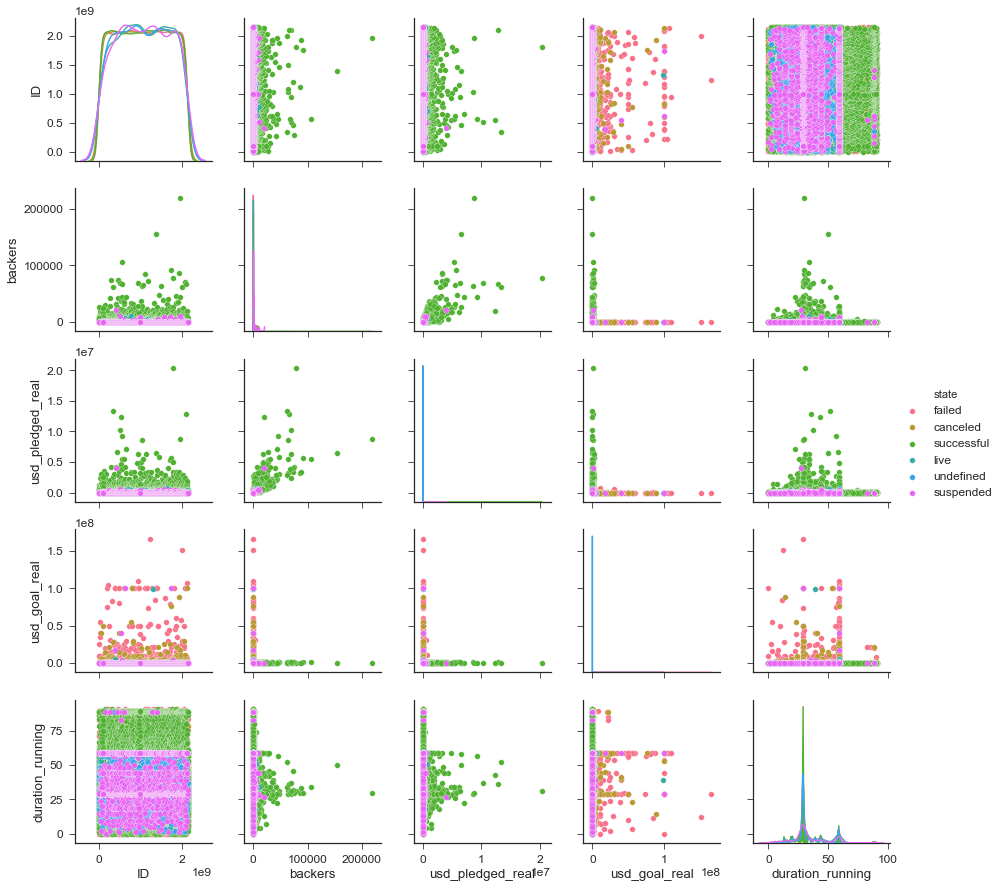

In [17]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
np.seterr(divide='ignore', invalid='ignore')
sns.pairplot(raw_data, hue = 'state', diag_kind = "kde", kind = "scatter", palette = "husl")
plt.show()

<font color = 'dodgerblue'>
<ul> 
<li> backers and usd_pledged_real are positively correlated </li> 
<li> backers, usd_goal_real, usd_pledged_real have extremely right skewed distributions </li>
<li> duration_running has an interesting peak suggesting that maimum projects have that range of duration between launch and deadline </li>
</ul>
</font>

##### Checking distributions

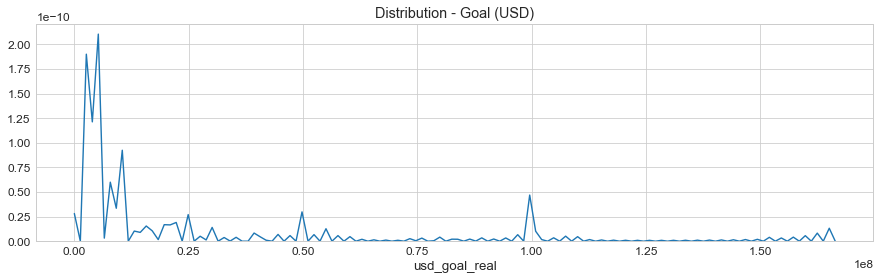

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Distribution - Goal (USD)')
sns.distplot(raw_data['usd_goal_real'], hist = False)
plt.show()

<font color = 'dodgerblue'>
<ul> 
<li> Maximum projects have goal < 10 M </li>
<li> Interesting small peaks where goal = 25M, 50M and 100M </li> 
</ul>
</font>

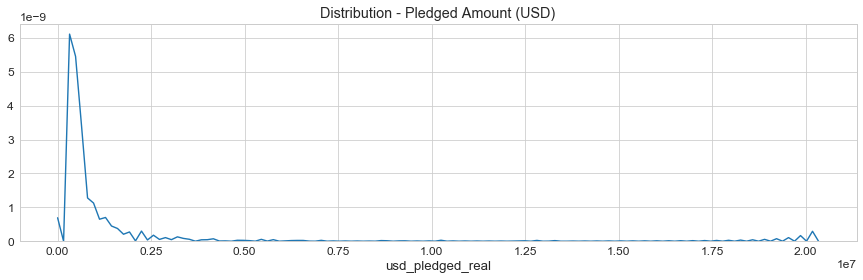

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Distribution - Pledged Amount (USD)')
plt.ylim(0, 0.000000001)
sns.distplot(raw_data['usd_pledged_real'], hist = False)
plt.show()

<font color = 'dodgerblue'>
<ul> 
<li> Maximum projects have pledged amount < 1 M </li>
</ul>
</font>

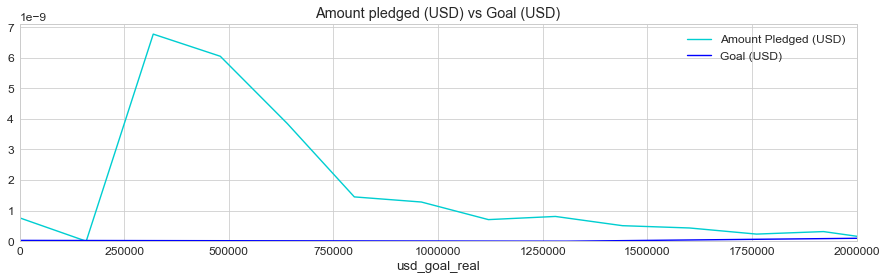

In [80]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Amount pledged (USD) vs Goal (USD)')
plt.xlim(0, 2000000)
sns.distplot(raw_data['usd_pledged_real'], hist = False, color = 'darkturquoise', label = 'Amount Pledged (USD)')
sns.distplot(raw_data['usd_goal_real'], hist = False, color = 'blue', label = 'Goal (USD)')
plt.show()

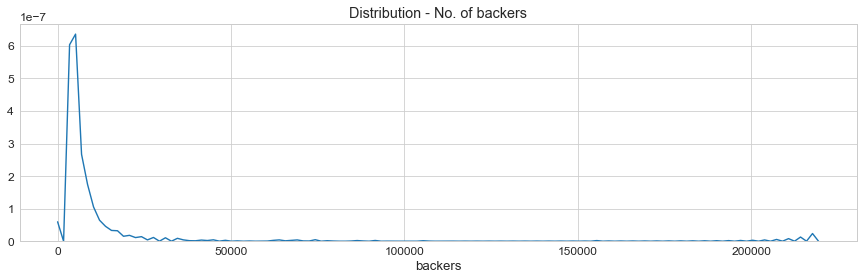

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Distribution - No. of backers')
sns.distplot(raw_data['backers'], hist = False)
plt.show()

<font color = 'dodgerblue'>
<ul> 
<li> There is a significant number of projects with 0 backers. Ideally projects with 0 backers must have failed due to lack of funding </li>
</ul>
</font>

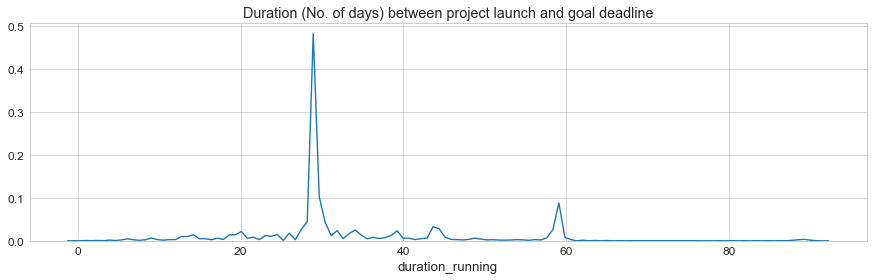

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Duration (No. of days) between project launch and goal deadline')
sns.distplot(raw_data['duration_running'], hist = False)
plt.show()

<font color = 'dodgerblue'>
<ul> 
<li> Maximum projects have duration_running as ~30 days or 1 month followed by another small peak at ~60 days or 2 months </li>
</ul>
</font>

##### Project Count by Status

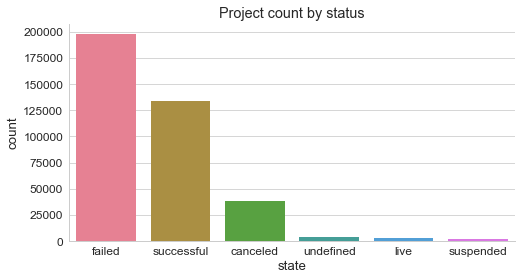

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize = (8,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Project count by status')
sns.countplot(raw_data['state'], palette = 'husl', order = raw_data['state'].value_counts().index)
sns.despine(top = True, right = True)

<font color = 'dodgerblue'>
<ul> 
<li> Successful Projects = 35% </li>
<li> Failed Projects = 52% </li> 
<li> Other Projects = 13% </li> 
<li> It will be best to delete projects with state other than 'successful' or 'failed' before modeling </li> 
</ul>
</font>

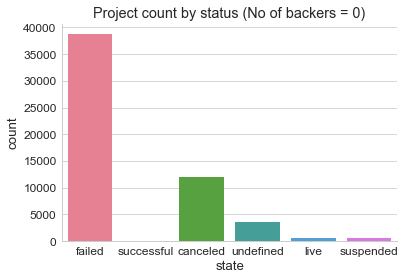

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize = (6,4))
sns.set_context("paper", font_scale=1.5)
plt.title('Project count by status (No of backers = 0)')
sns.countplot(raw_data['state'][(raw_data.backers == 0)], palette = 'husl', order = raw_data['state'].value_counts().index)
sns.despine(top = True, right = True)

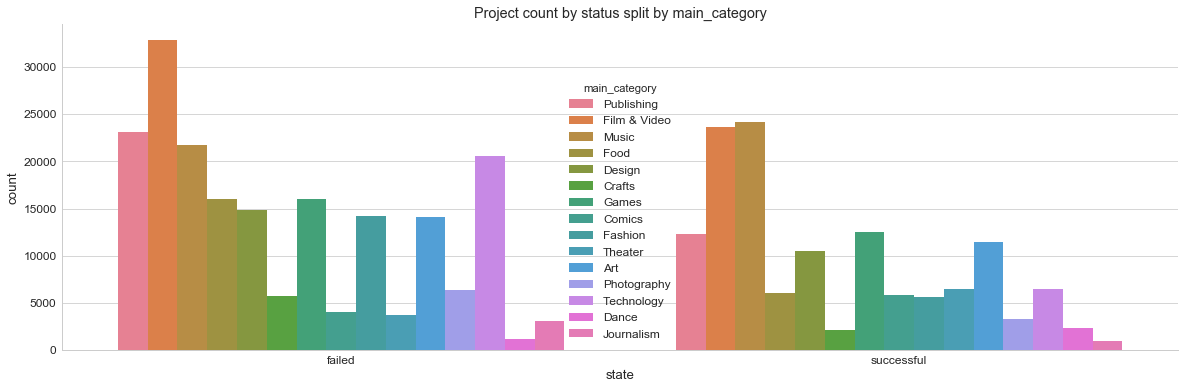

In [25]:
success_fail_df = raw_data[raw_data.state.isin(['successful', 'failed'])]
sns.set_style("whitegrid")
plt.figure(figsize = (20,6))
sns.set_context("paper", font_scale=1.5)
plt.title('Project count by status split by main_category')
sns.countplot(success_fail_df['state'], hue = raw_data['main_category'], palette = 'husl')
sns.despine(top = True, right = True)

<font color = 'red'>
<ul> 
<li> What is the insight?? </li> 
</ul>
</font>

##### Project status by goal (USD) and pledged amount (USD)

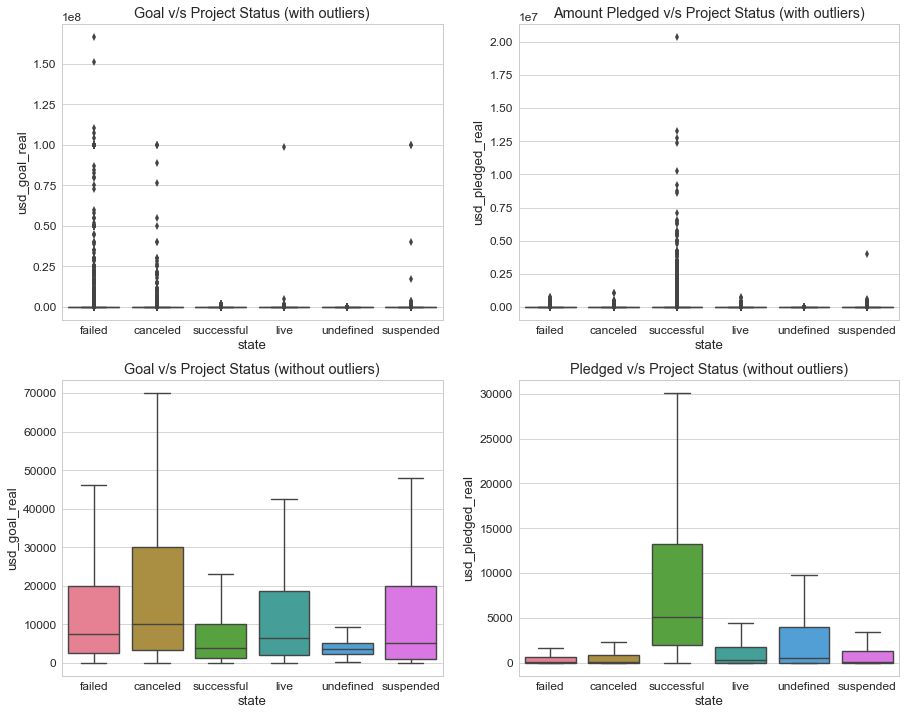

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,12))
sns.set_context("paper", font_scale=1.5)
plt.subplot(2,2,1)
plt.title('Goal v/s Project Status (with outliers)')
sns.boxplot(x='state',y='usd_goal_real',data=raw_data, palette="husl")
plt.subplot(2,2,2)
plt.title('Amount Pledged v/s Project Status (with outliers)')
sns.boxplot(x='state',y='usd_pledged_real',data=raw_data, palette="husl")
plt.subplot(2,2,3)
plt.title('Goal v/s Project Status (without outliers)')
sns.boxplot(x='state',y='usd_goal_real',data=raw_data, palette="husl", showfliers=False)
plt.subplot(2,2,4)
plt.title('Pledged v/s Project Status (without outliers)')
sns.boxplot(x='state',y='usd_pledged_real',data=raw_data, palette="husl", showfliers=False)
plt.show()

<font color = 'dodgerblue'>
<ul> 
<li> Too many outliers in both the plots but there is a clear insight -> Successful projects were the ones where pledged amount was really high compared to all other projects where the ones whose goal was extremely high </li> 
<li> This insight gives a potential feature -> differential = (pledged - goal) -> Higher this value, higher the chance of success </li>
</ul>
</font>

##### Project status by no of backers

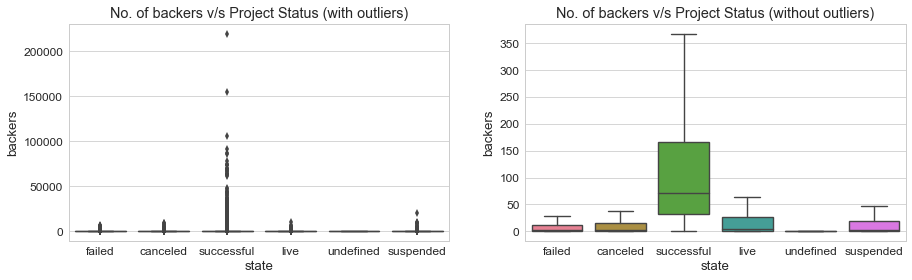

In [27]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,4))
sns.set_context("paper", font_scale=1.5)
plt.subplot(1,2,1)
plt.title('No. of backers v/s Project Status (with outliers)')
sns.boxplot(x='state',y='backers',data=raw_data, palette="husl")
plt.subplot(1,2,2)
plt.title('No. of backers v/s Project Status (without outliers)')
sns.boxplot(x='state',y='backers',data=raw_data, palette="husl", showfliers = False)
plt.show()

<font color = 'blue'>
* Clearly, successful projects have higher number of backers
</font>

##### Project Status by goal (USD) and pledged amount (USD)

In [29]:
# # # Success proportion based on main_category
# raw_data[['main_category', 'is_successful']].groupby(['main_category'], as_index = False).mean()

In [30]:
# # # Success proportion based on country
# raw_data[['country', 'is_successful']].groupby(['country'], as_index = False).mean()

##### Project Count by Country

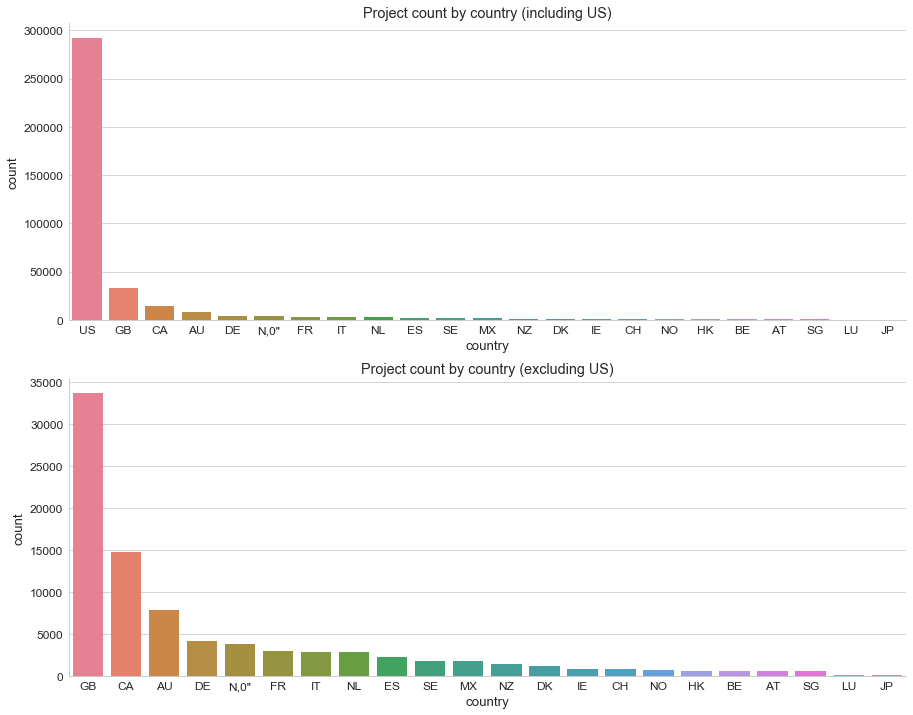

In [31]:
non_US_country_list = raw_data[raw_data.country != 'US']
sns.set_style("whitegrid")
plt.figure(figsize = (15,12))
sns.set_context("paper", font_scale=1.5)
plt.subplot(2,1,1)
plt.title('Project count by country (including US)')
sns.countplot(raw_data['country'], palette = 'husl', order = raw_data['country'].value_counts().index)
sns.despine(top = True, right = True)
plt.subplot(2,1,2)
plt.title('Project count by country (excluding US)')
sns.countplot(non_US_country_list['country'], palette = 'husl', order = non_US_country_list['country'].value_counts().index)
sns.despine(top = True, right = True)

<font color = 'blue'>
    <ul>
        <li> Clearly, US has the majority of projects (77%) </li>
        <li> GB and CA are next followed by rest of the 19 countries </li>
    </ul>
</font>

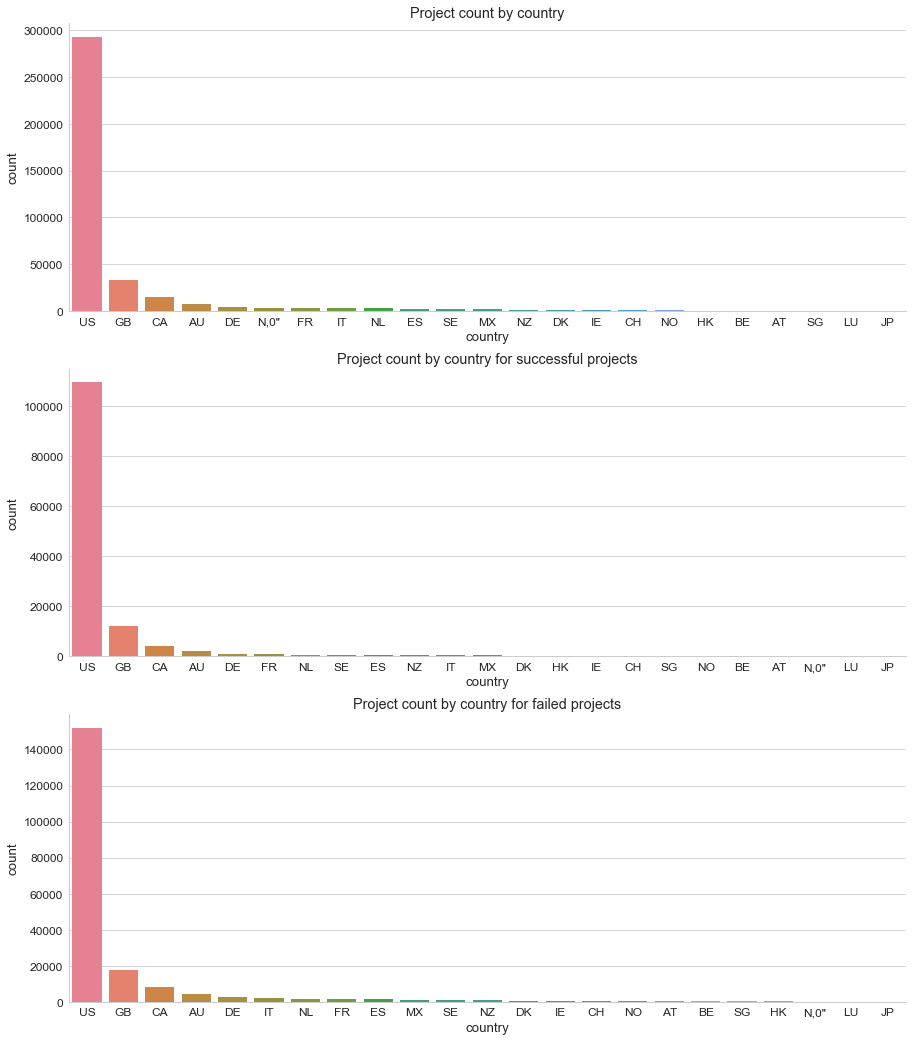

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,18))
plt.subplot(3,1,1)
plt.title('Project count by country')
sns.countplot(raw_data['country'], palette = 'husl', order = raw_data['country'].value_counts().index)
sns.despine(top = True, right = True)
plt.subplot(3,1,2)
plt.title('Project count by country for successful projects')
sns.countplot(raw_data['country'][raw_data.state == 'successful'], palette = 'husl', order = raw_data['country'][raw_data.state == 'successful'].value_counts().index)
sns.despine(top = True, right = True)
plt.subplot(3,1,3)
plt.title('Project count by country for failed projects')
sns.countplot(raw_data['country'][raw_data.state == 'failed'], palette = 'husl', order = raw_data['country'][raw_data.state == 'failed'].value_counts().index)
sns.despine(top = True, right = True)

<font color = 'blue'>
    <ul>
        <li> Order of top 5 countries is same for both successful and failed projects </li>
        <li> Rest of the 18 countries have significantly less share of projects </li>
    </ul>
</font>

##### Project Status by Main Catergory

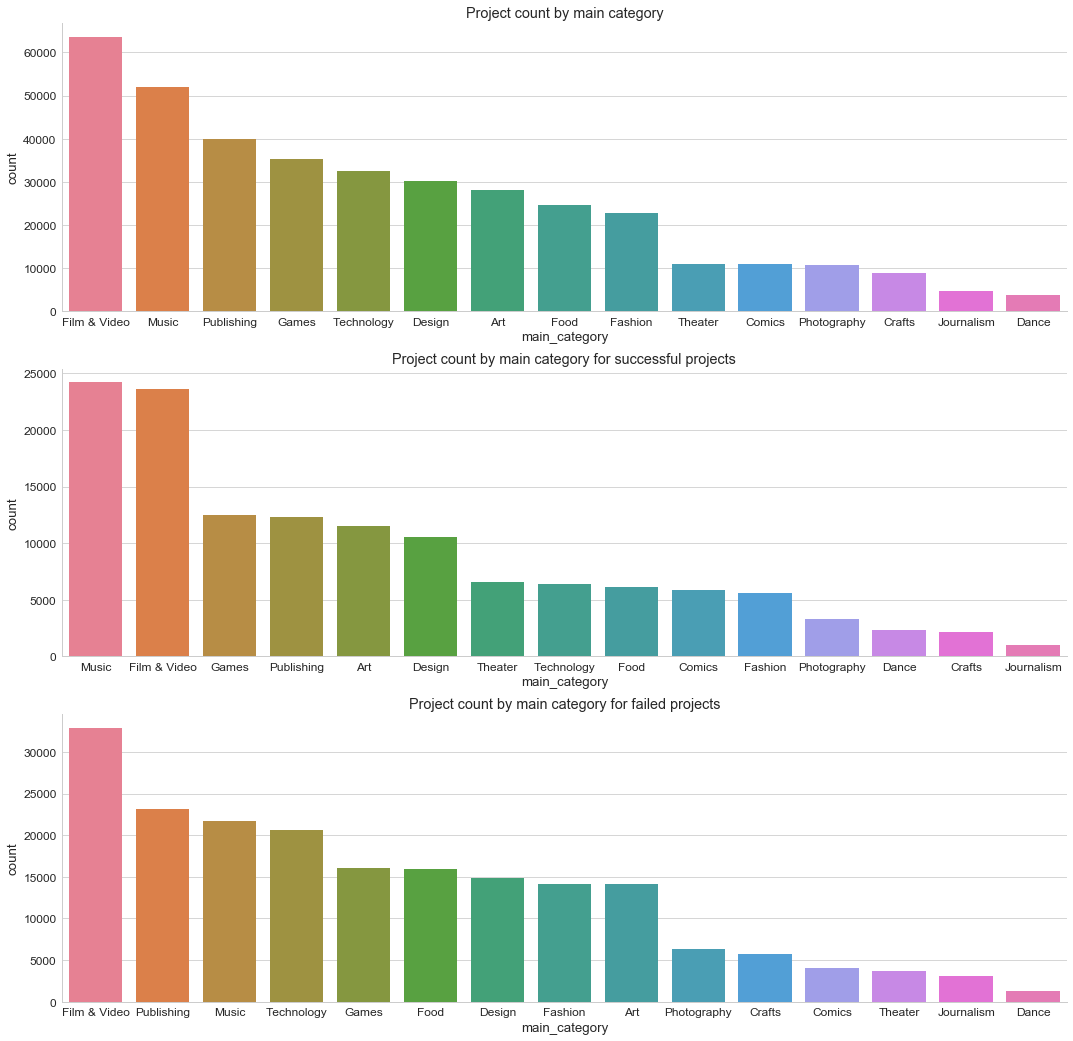

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,18))
plt.subplot(3,1,1)
plt.title('Project count by main category')
sns.countplot(raw_data['main_category'], palette = 'husl', order = raw_data['main_category'].value_counts().index)
sns.despine(top = True, right = True)
plt.subplot(3,1,2)
plt.title('Project count by main category for successful projects')
sns.countplot(raw_data['main_category'][raw_data.state == 'successful'], palette = 'husl', order = raw_data['main_category'][raw_data.state == 'successful'].value_counts().index)
sns.despine(top = True, right = True)
plt.subplot(3,1,3)
plt.title('Project count by main category for failed projects')
sns.countplot(raw_data['main_category'][raw_data.state == 'failed'], palette = 'husl', order = raw_data['main_category'][raw_data.state == 'failed'].value_counts().index)
sns.despine(top = True, right = True)

<font color = 'blue'>
    <ul>
        <li> This chart gives multiple insights and if needed a deep dive could be done into each of the interesting main_category and their sub_categories </li>
        <li> For instance, 'Technology' has 5th highest number of projects, 4th highest number of failed projects, and only eighth in the number of successful projects. Clearly not a great category to be in compared to say 'Music' </li>
    </ul>
</font>

### Preprocessing

In [35]:
# Drop all projects with state other than 'successful' and 'failed'
raw_data.drop(raw_data[(raw_data.state != 'successful') & (raw_data.state != 'failed')].index, inplace=True)

In [36]:
# Drop all projects with country N,0"
raw_data.drop(raw_data[raw_data.country == 'N,0"'].index, inplace=True)

In [37]:
raw_data['is_successful'] = (raw_data['state'] == 'successful').astype(int)

In [38]:
raw_data['is_US'] = (raw_data['country'] == 'US').astype(int)

In [39]:
data = pd.get_dummies(raw_data, columns=["main_category"])

In [40]:
data.drop(['category', 'country', 'state', 'name'], axis = 1, inplace = True)

In [41]:
data.head()

,ID,backers,usd_pledged_real,usd_goal_real,duration_running,is_successful,is_US,main_category_Art,main_category_Comics,main_category_Crafts,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000002330,0,0.0,1533.95,58,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,15,2421.0,30000.00,59,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,3,220.0,45000.00,44,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,1,1.0,5000.00,29,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,224,52375.0,50000.00,34,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [42]:
#cols = data.columns.tolist()
cols = ['ID', 'is_successful', 'backers', 'usd_pledged_real', 'usd_goal_real', 'duration_running','is_US', 
        'main_category_Art', 'main_category_Comics', 'main_category_Crafts', 'main_category_Dance', 
        'main_category_Design', 'main_category_Fashion', 'main_category_Film & Video', 'main_category_Food', 
        'main_category_Games', 'main_category_Journalism', 'main_category_Music', 'main_category_Photography', 
        'main_category_Publishing', 'main_category_Technology', 'main_category_Theater']
data_final = data[cols]
data_final.head()

,ID,is_successful,backers,usd_pledged_real,usd_goal_real,duration_running,is_US,main_category_Art,main_category_Comics,main_category_Crafts,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000002330,0,0,0.0,1533.95,58,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,0,15,2421.0,30000.00,59,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,0,3,220.0,45000.00,44,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,0,1,1.0,5000.00,29,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,1,224,52375.0,50000.00,34,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [43]:
X = data_final.drop(['ID', 'is_successful'], axis = 1)
y = data['is_successful']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [62]:
data_final.head()

,ID,is_successful,backers,usd_pledged_real,usd_goal_real,duration_running,is_US,main_category_Art,main_category_Comics,main_category_Crafts,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000002330,0,0,0.0,1533.95,58,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1000003930,0,15,2421.0,30000.00,59,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1000004038,0,3,220.0,45000.00,44,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1000007540,0,1,1.0,5000.00,29,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,1000014025,1,224,52375.0,50000.00,34,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Model Selection

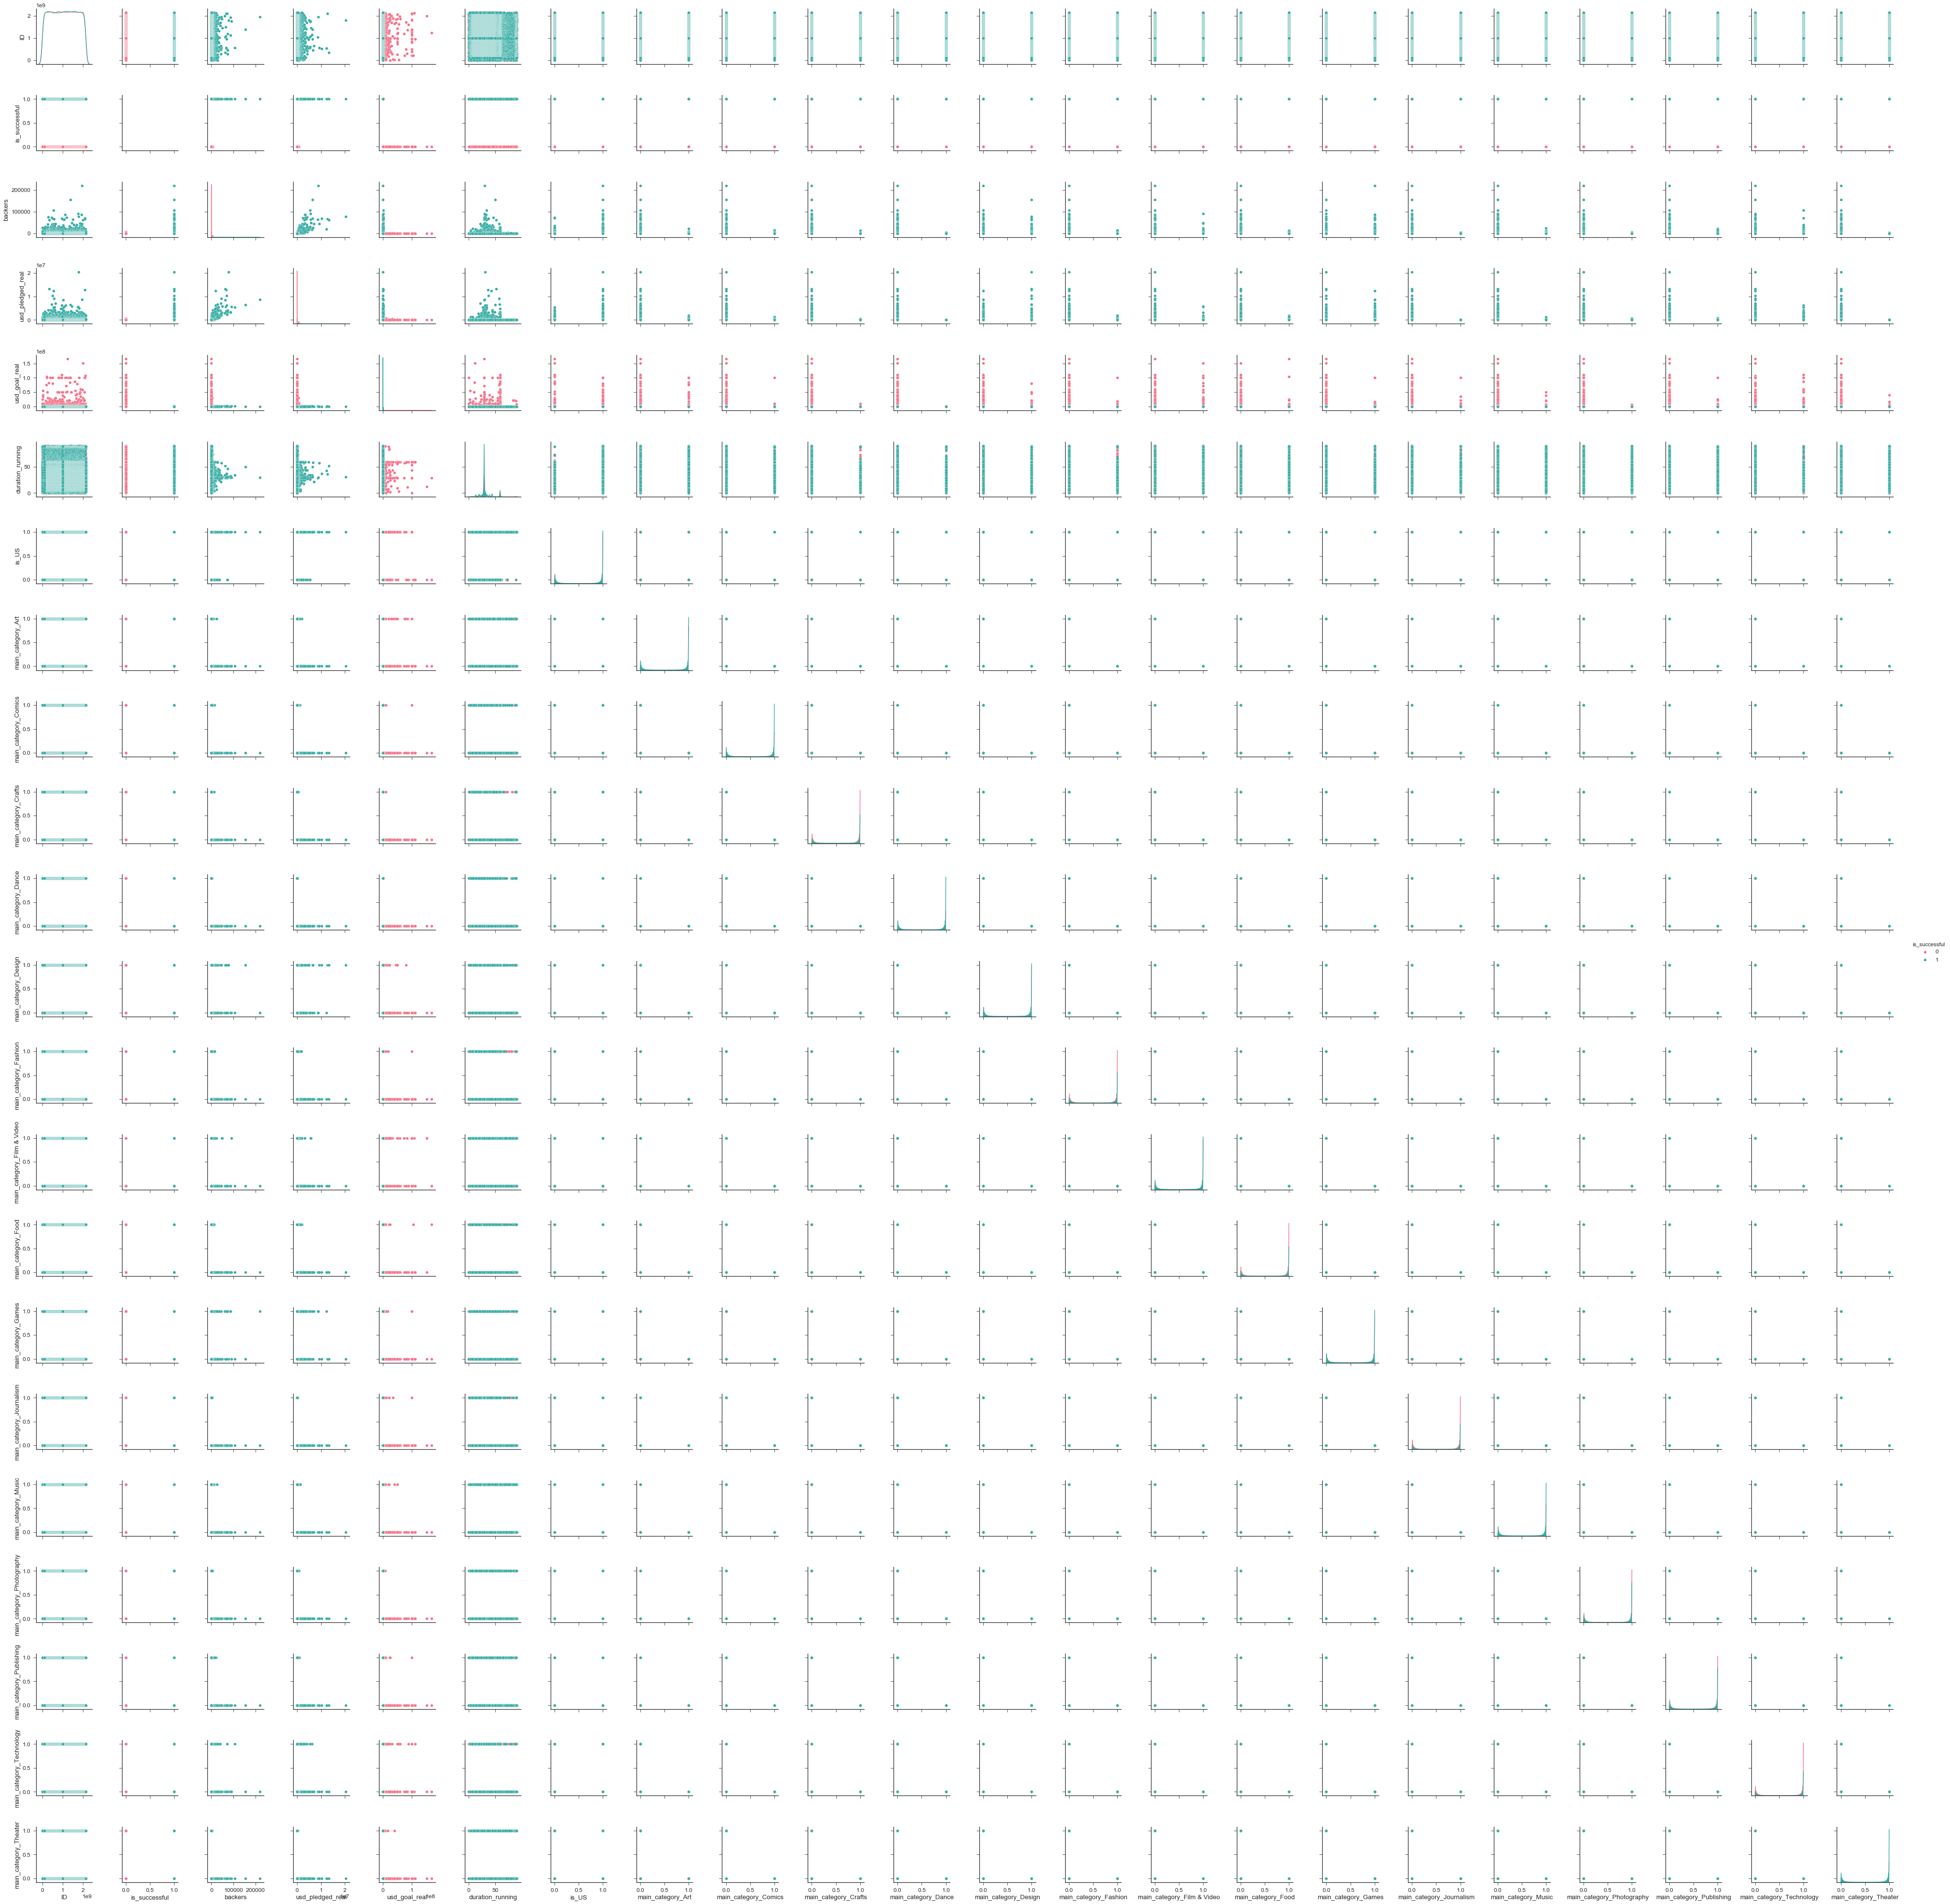

In [81]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
np.seterr(divide='ignore', invalid='ignore')
sns.pairplot(data_final, hue = 'is_successful', diag_kind = "kde", kind = "scatter", palette = "husl")
plt.show()

In [54]:
# Naive Bayes 
model = GaussianNB()
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.707767034227


In [55]:
# Naive Bayes with scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
model = GaussianNB()
model = model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.730605041256


In [56]:
# Logistic Regression
model = LogisticRegression()
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.998672559697


In [57]:
# Random Forest
model = RandomForestClassifier()
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.99603276364


In [45]:
# Decision Trees
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.999200518908


### Model Evaluation

In [75]:
# Applying kfold cross-validation on DecisionTreeClassifier Model
kf = KFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kf):
    model.fit(X_train.iloc[train], y_train.iloc[train])
    score = model.score(X_train.iloc[test], y_train.iloc[test])
    scores.append(score)
    print('Fold %2d), Class dist.:%s, Accu: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))

Fold  1), Class dist.:[142241  96413], Accu: 0.997
Fold  2), Class dist.:[142196  96458], Accu: 0.995
Fold  3), Class dist.:[142330  96325], Accu: 0.996
Fold  4), Class dist.:[142304  96351], Accu: 0.996
Fold  5), Class dist.:[142178  96477], Accu: 0.995
Fold  6), Class dist.:[142120  96535], Accu: 0.996
Fold  7), Class dist.:[142244  96411], Accu: 0.997
Fold  8), Class dist.:[142195  96460], Accu: 0.997
Fold  9), Class dist.:[142201  96454], Accu: 0.996
Fold 10), Class dist.:[142252  96403], Accu: 0.996


### Tuning Hyperparameters

In [78]:
param_range = range(1,20)
param_grid = {'max_depth': param_range}
gs = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.995587769448
{'max_depth': 19}


In [79]:
final_model = gs.best_estimator_
final_model.fit(X_train, y_train)
print('Test accuracy: %.3f' %final_model.score(X_test, y_test))

Test accuracy: 0.995
